# Anpassung der Resonanzkurve und Bestimmung von $\Delta\Omega$

Mit dem folgenden Code-Fragment zeigen wir Ihnen:
    
 * Wie man ein **geeignetes Modell** an die prozessierten Daten anpasst.
 * Wie man die **angepasste Funktion** gewinnt.
 * Wie man in mit Hilfe der *scypi*-Funktionen [fmin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html) und [fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) den **$x$-Wert für das Maximum/Minimum oder bestimmte Schnittpunkte** bestimmt. 

###############
# Fit Results #
###############

    Model Parameters

        k = 0.873 +/- 0.048
        omega0 = 3.3756 +/- 0.0063
        lambda0 = -0.0639 +/- 0.0093

    Model Parameter Correlations

                 k        omega0   lambda0
                 =======  =======  =======
        k        1.0      0.2624   -0.7683
        omega0   0.2624   1.0      -0.4319
        lambda0  -0.7683  -0.4319  1.0    

    Cost Function

        Cost function: chi-square (with covariance matrix)

        chi2 / ndf = 13.08 / 10 = 1.308

        chi2 probability = 0.220

OrderedDict({'k': np.float64(0.8729181747989906), 'omega0': np.float64(3.375592203784703), 'lambda0': np.float64(-0.06393978582236191)})


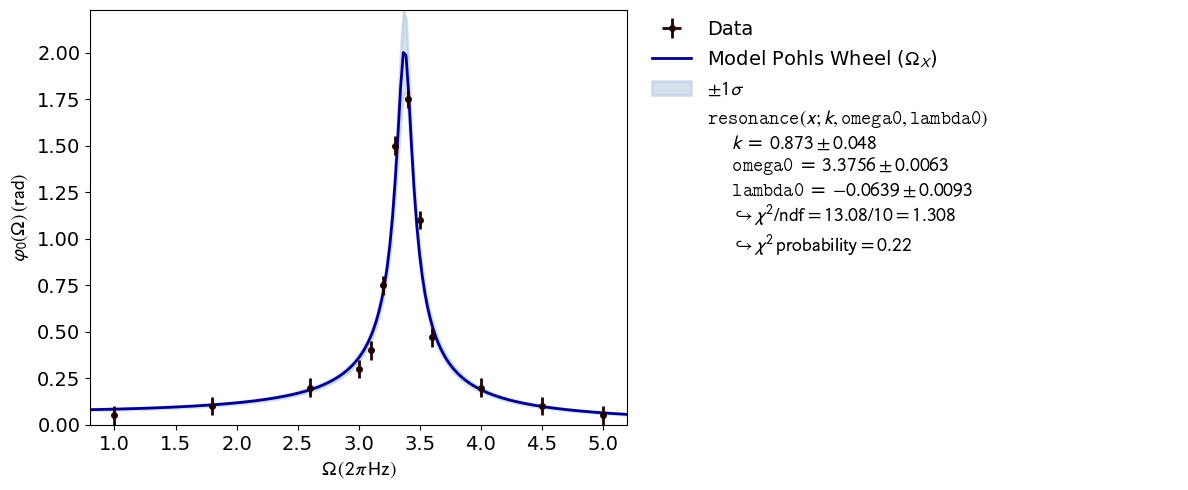

In [18]:
import numpy as np
from kafe2 import XYContainer

# We 
Omega = [ 1.0,  1.8,  2.6,  3.0,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  4.0,  4.5,  5.0]
phi0  = [0.05, 0.10, 0.20, 0.30, 0.40, 0.75, 1.50, 1.75, 1.10, 0.47, 0.20, 0.10, 0.05]

# Fill XYContainer
xy_data = XYContainer(x_data=Omega, y_data=phi0)
# We add some arbitrary uncertaintes here
xy_data.add_error(axis="x", err_val=0.0125)
xy_data.add_error(axis="y", err_val=0.0500)
xy_data.label = "Data"

from kafe2 import Fit, Plot, ContoursProfiler

# Fit model, we start of with a damped oscillation, and potentially extend by 
# a linear extra term to additional frictional effects of the wheel. The POIs 
# (parameters of interest) are lambda0 and omega0.
def resonance(x, k=1.5, omega0=3.1, lambda0=0.2):
      return k/np.sqrt((omega0**2-x**2)**2+(2*lambda0*x)**2)
# Declare and do the fit with a bit of cosmetic customization
fit = Fit(xy_data, model_function=resonance)
#fit.assign_model_function_latex_name(r"\Omega_{X}")
#fit.assign_parameter_latex_names(
#    lambda0 = r"\lambda_{0}", 
#    x0      = r"x_{0}", 
#    omega0  = r"\omega_{0}",
#    phi0    = r"\phi_{0}",
#    a       = r"a"
#)
# Set limits for parameters if needed. 
#fit.limit_parameter("phi0", lower=-180., upper=180.)
#fit.limit_parameter("x0", lower=0.)
# Do the fit
results=fit.do_fit()
# Return a reasonably clean report
fit.report(show_data=False, show_model=False)

# Plot the result with a bit of customization
plot = Plot(fit_objects=fit)
plot.customize('model_line', 'label', [(0, r'Model Pohls Wheel ($\Omega_{X}$)')])
plot.customize('model_line', 'color', [(0, 'darkblue')])
plot.customize('model_line', 'linestyle', [(0, 'solid')])
plot.customize('model_error_band', 'label', [(0, r'$\pm1\sigma$')])
plot.customize('model_error_band', 'color', [(0, 'lightsteelblue')])
plot.x_label = r'$\Omega\,(2\pi\,\mathrm{Hz})$'
plot.y_label = r'$\varphi_{0}(\Omega)\,(\mathrm{rad})$'
plot.plot()  

# Create contour plots, this step should only be used when using less than 300 
# data points, since it may take really long otherwise
#cpf = ContoursProfiler(fit)
#cpf.plot_profiles_contours_matrix()

# Show plot in notebook
plot.show()

In [ ]:
from scipy.optimize import fsolve, fmin

# In case you want to evaluate the fitted function at any point per hand (this 
# can be very useful to convince yourself that what is done below does what you 
# expect it to do)
#fnc_values = fit.eval_model_function(x=np.array([1.0, 2.5, 3.4, 4.5]))

# One way to define the function with the fitted parameters
def fitted_fnc(x): 
    return resonance(x, 
        k = results["parameter_values"]["k"], 
        omega0 = results["parameter_values"]["omega0"], 
        lambda0 = results["parameter_values"]["lambda0"]
    )
# Find the location of the maximum of fitted_fnc on the x-axis
x_max = fmin(lambda x: -fitted_fnc(x), 0)

# One way to define DeltaOmega=x_upper-x_lower. Be sure that the root finding 
# by fslove is close to the roots that you expect. In this case we chose start 
# values for the search 5% left and right of x_max
x_upper = fsolve(lambda x: fitted_fnc(x)-fitted_fnc(x_max)/np.sqrt(2),1.05*x_max)
x_lower = fsolve(lambda x: fitted_fnc(x)-fitted_fnc(x_max)/np.sqrt(2),0.95*x_max)

print("Results of the search for DeltaOmega:")
print("-------------------------------------")
print("Omega_max  = ", x_max)
print("DeltaOmega = ", x_upper-x_lower)
print("Q          = ", x_max/(x_upper-x_lower))